In [1]:
import os, sys
import numpy as np
import h5netcdf

import xarray as xr
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(18,8))
plt.rc("font", size=14)
ccrs.PlateCarree()

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4)
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34765 instead
  warnings.warn(


<Client: 'inproc://137.129.155.67/61951/1' processes=1 threads=4, memory=78.61 GiB>

In [2]:
indir_smot = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/SMOTHED_CLIM/'
indir_brut = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_CLIM/'
output_fig = '/cnrm/tropics/commun/DATACOMMUN/WAVE/RAPPORT/FIGURES/CLIM/'

var = 'tcwv'

ds_brut = xr.open_mfdataset(indir_brut+'clim_tcwv_brut_ERA5_3H_1990_2020.nc', chunks = {'time' : 1}, engine="h5netcdf", parallel=True)
ds_smot = xr.open_mfdataset(indir_smot+'*'+var+'*2020.nc', chunks = {'time' : 1}, engine="h5netcdf", parallel=True)

ds_brut = ds_brut.sel(latitude = slice(30.1,-30.1))
ds_smot = ds_smot.sel(latitude = slice(30.1,-30.1))



# Verification 1D entre les données brutes et les données smoothed
Cette vérification est faite sur trois points du globe, Afrique, Océan Indien et Océan Pacifique

In [ ]:
latitude = 10
longitude = [0, 90, 180]

plt.figure()
ds_brut['tcwv'].sel(latitude = latitude, longitude = longitude).plot(hue='longitude')
ds_smot['tcwv_smooth'].sel(latitude = latitude, longitude = longitude).plot(hue='longitude')
plt.grid()
# plt.legend()
plt.show()

# Verification 2D

In [ ]:
ds_MMS = ds_smot.groupby('time.month').mean('time').load()
ds_MSS = ds_smot.groupby('time.season').mean('time').load()


#### Carte global de PW en moyenne mensuelle

In [4]:
#### Parameter for plotting
colorbar = {'label': 'tcwv $kg.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(20.,60.1,2),
            'extend' : 'both'}
vmax = 60.
vmin = 20.
cmap ='RdBu'
size = 5

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-40.0, 
                         max_latitude=40.0, 
                         globe=None)

/home/durandy/miniconda3/envs/towel/lib/python3.8/site-packages/xarray/plot/facetgrid.py:394: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


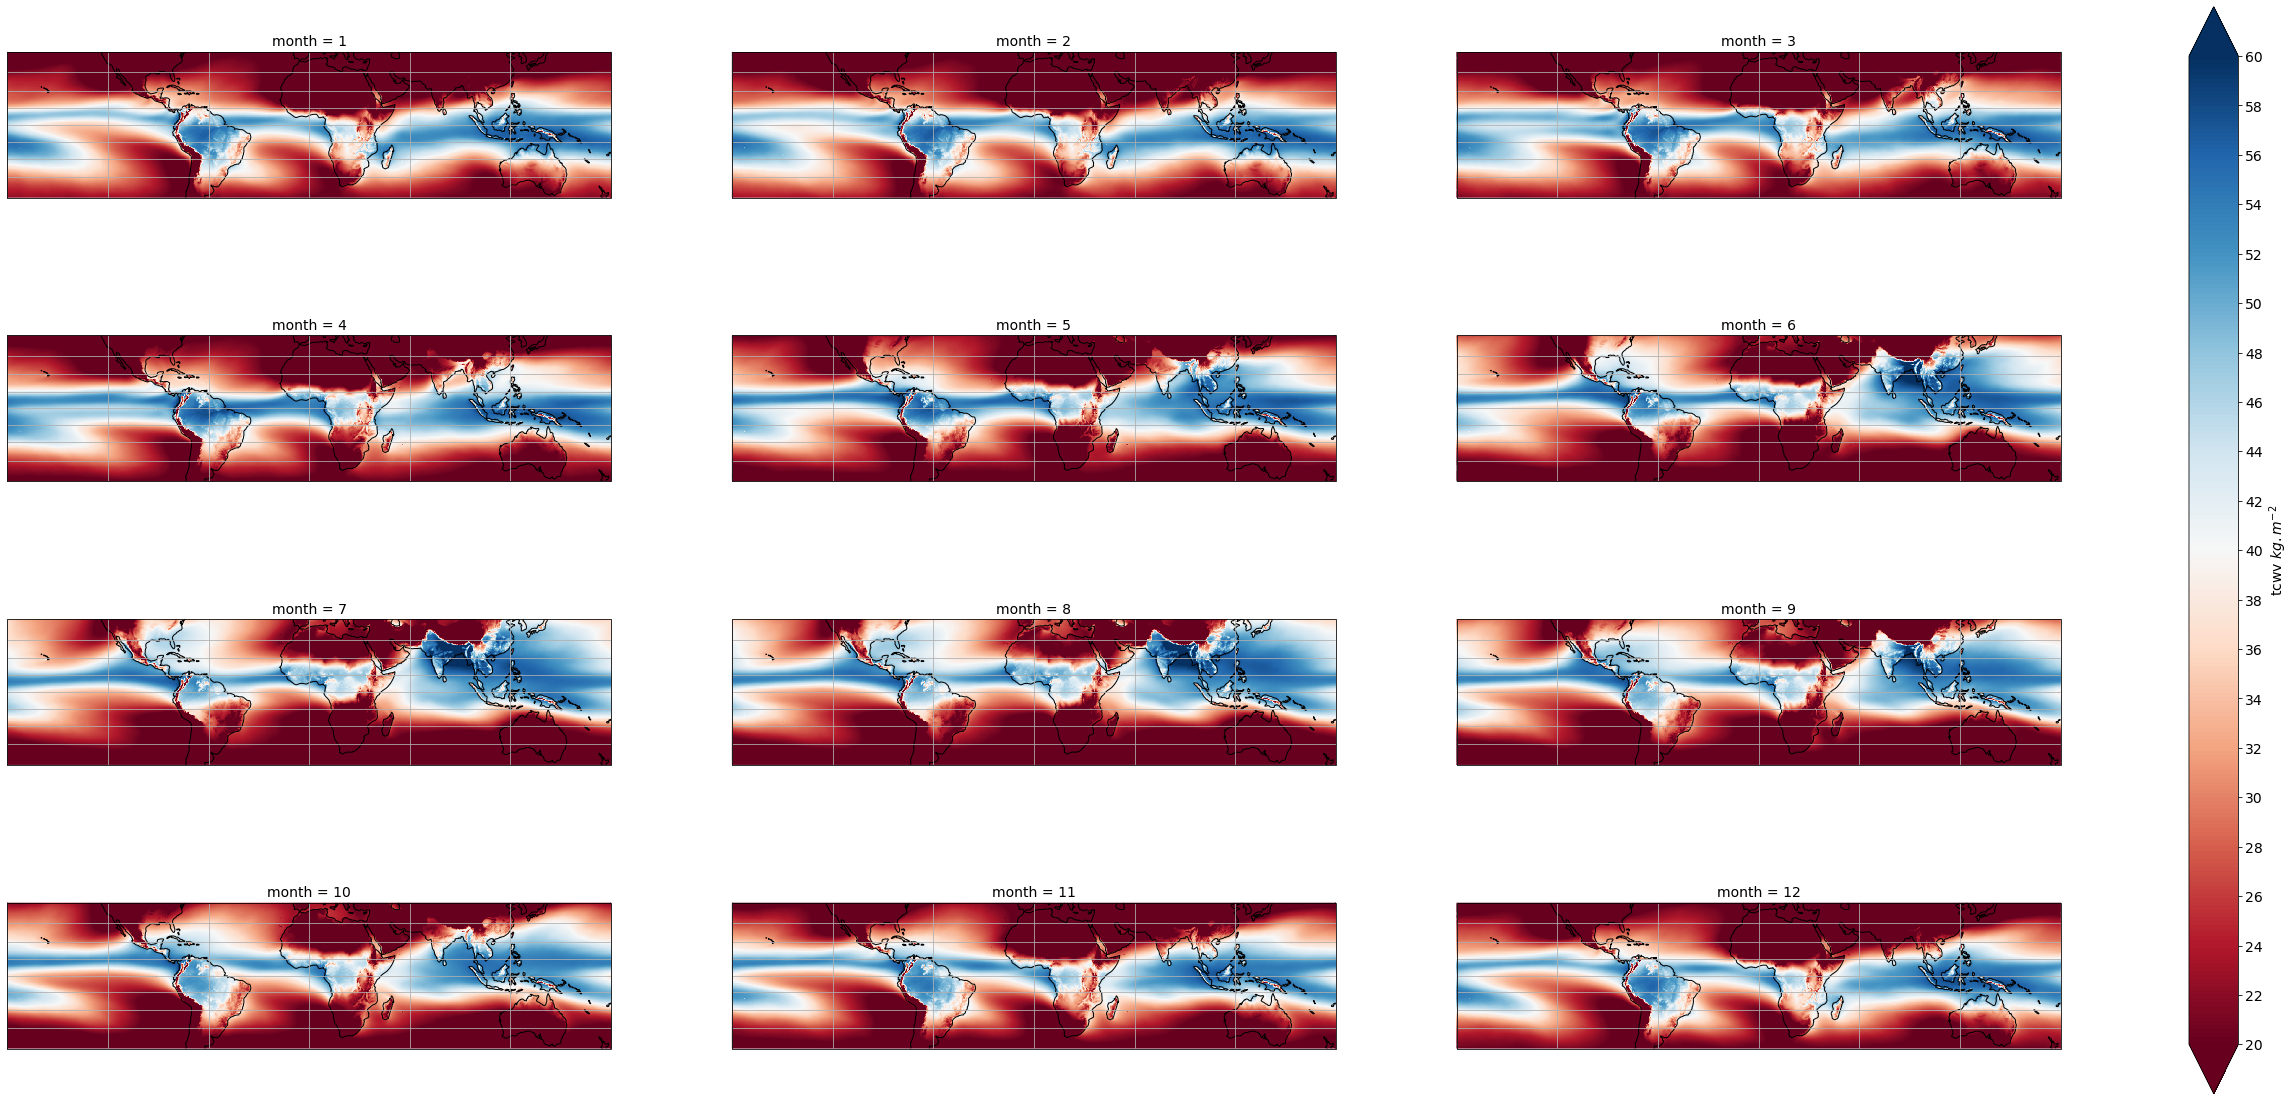

In [5]:


# plt.figure(figsize = (30,10))
p = ds_MMS['tcwv_smooth'].plot(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'month', col_wrap =3,
                               aspect = 3, size = size,
                               vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                               cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
    
plt.savefig(output_fig+'atlas_meanMonth_clim.png')  

#### Carte global de PW en moyenne saisonière

/home/durandy/miniconda3/envs/towel/lib/python3.8/site-packages/xarray/plot/facetgrid.py:394: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


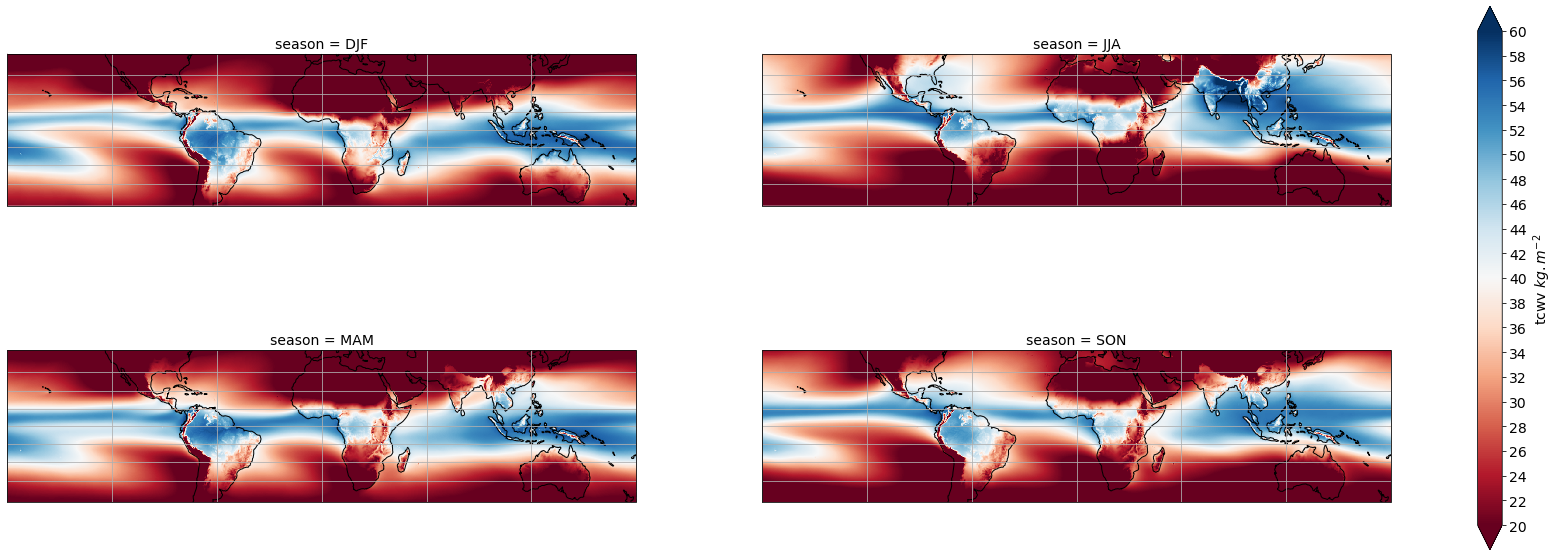

In [6]:
p = ds_MSS['tcwv_smooth'].plot(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'season', col_wrap =2,
                               aspect = 3, size = size,
                               vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                               cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
    
plt.savefig(output_fig+'atlas_meanSeason_clim.png')

# Calcul et carte de variance pour la variable tcwv

In [7]:
ds_std_smot = ds_smot.std('time')
ds_std_smot_M = ds_smot.groupby('time.month').std('time').load()
ds_std_smot_S = ds_smot.groupby('time.season').std('time').load()

ds_std_brut = ds_brut.std('time')
ds_std_brut_M = ds_brut.groupby('time.month').std('time')
ds_std_brut_S= ds_brut.groupby('time.season').std('time')



#### Parameter for plotting
colorbar = {'label': 'tcwv $kg.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(0.,5.1,0.5),
            'extend' : 'max'}
vmax = 5.
vmin = 0.
cmap ='RdBu'
size = 5
aspect = 4

#### Atlas de la variance sur les douze mois 

/home/durandy/miniconda3/envs/towel/lib/python3.8/site-packages/xarray/plot/facetgrid.py:394: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


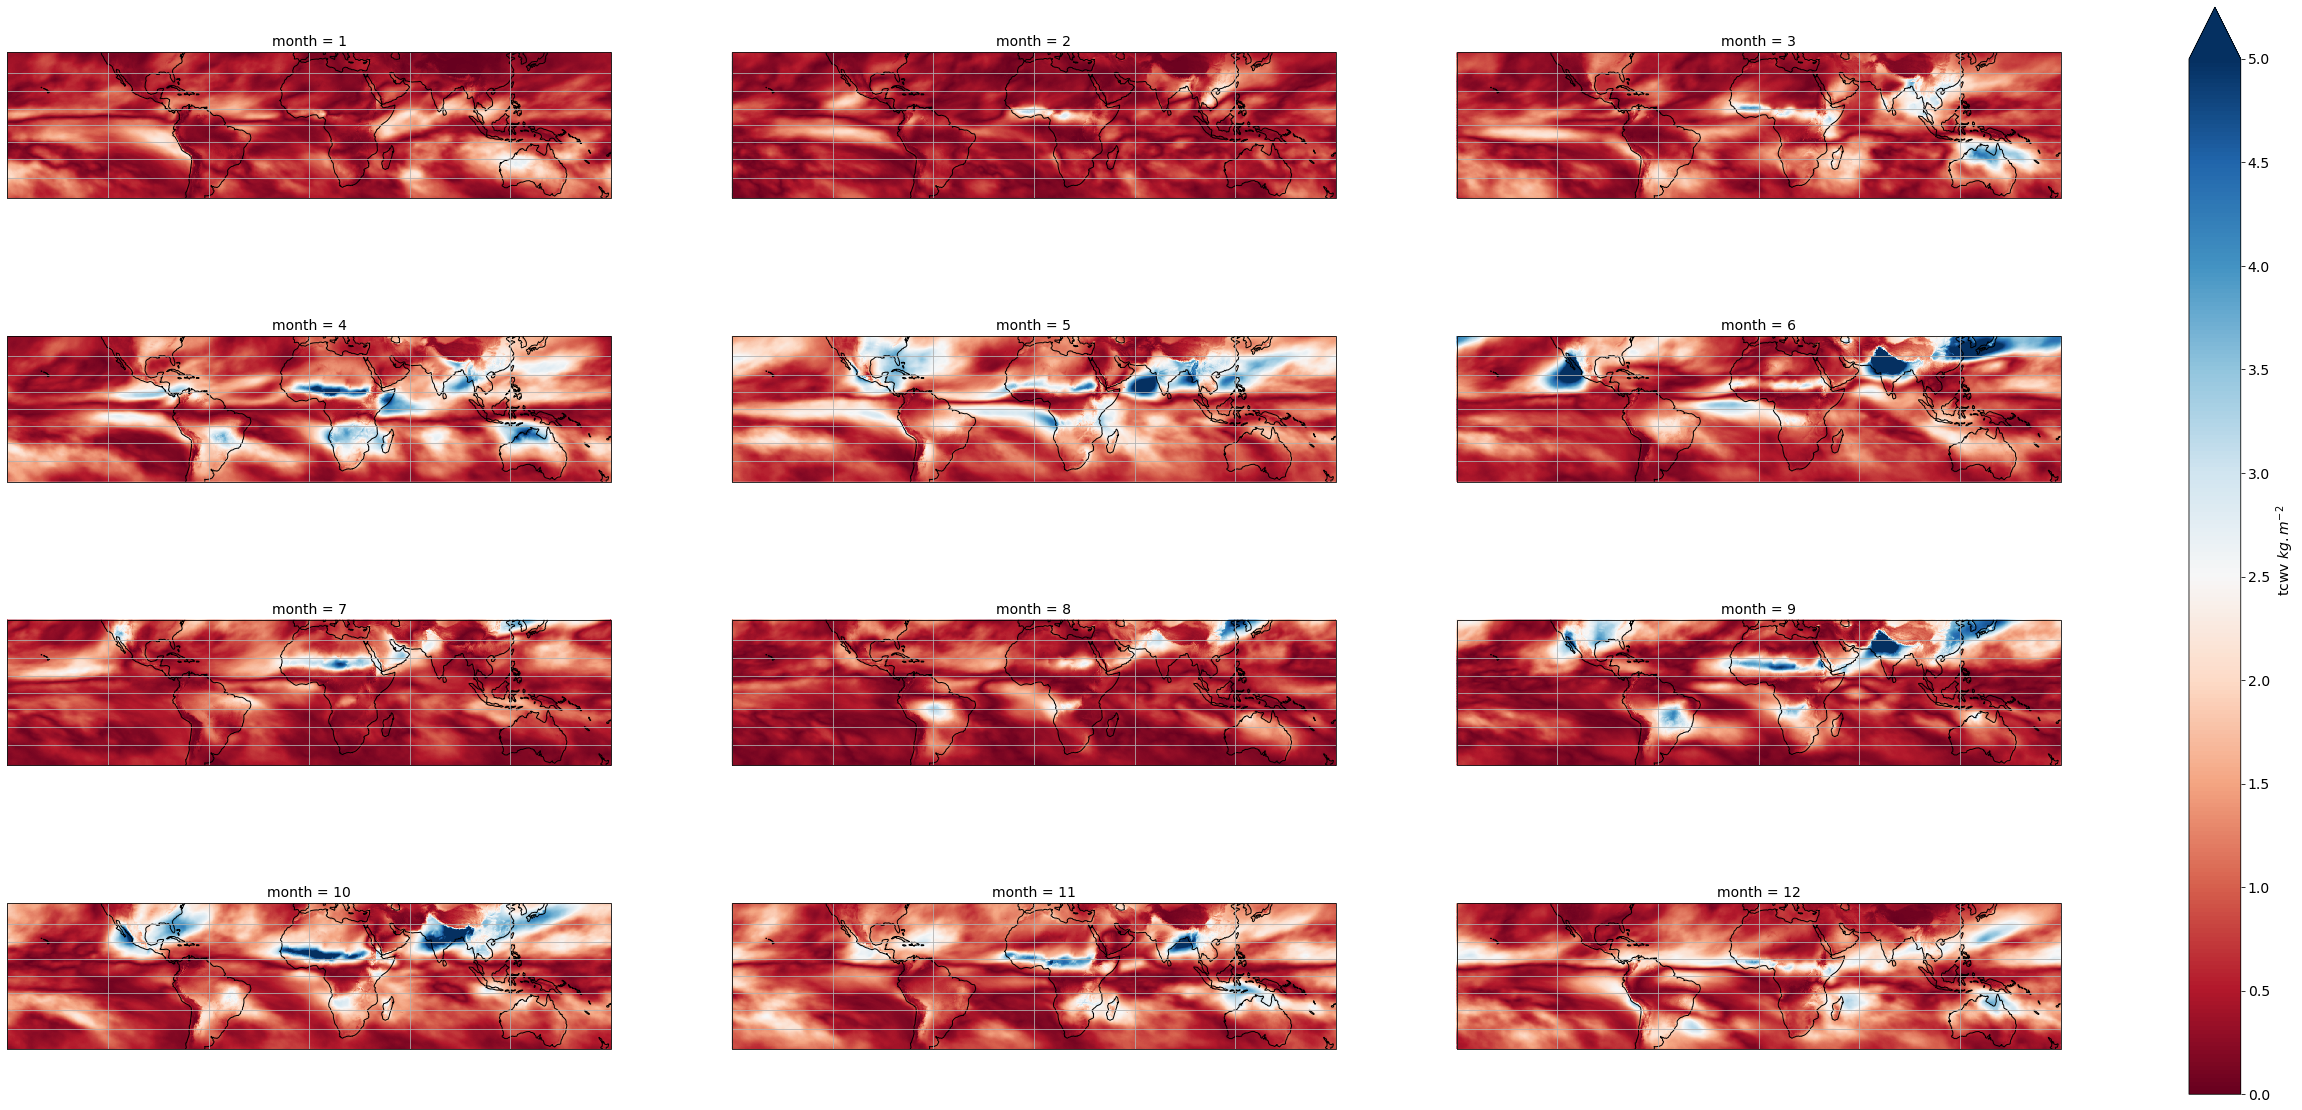

In [8]:
p = ds_std_smot_M['tcwv_smooth'].plot(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'month', col_wrap =3,
                               aspect = aspect, size = size,
                               vmin = 0., vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                               cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
    
# plt.show()
plt.savefig(output_fig+'atlas_varMonth_clim.png')

#### Atlas de la variance saisonière

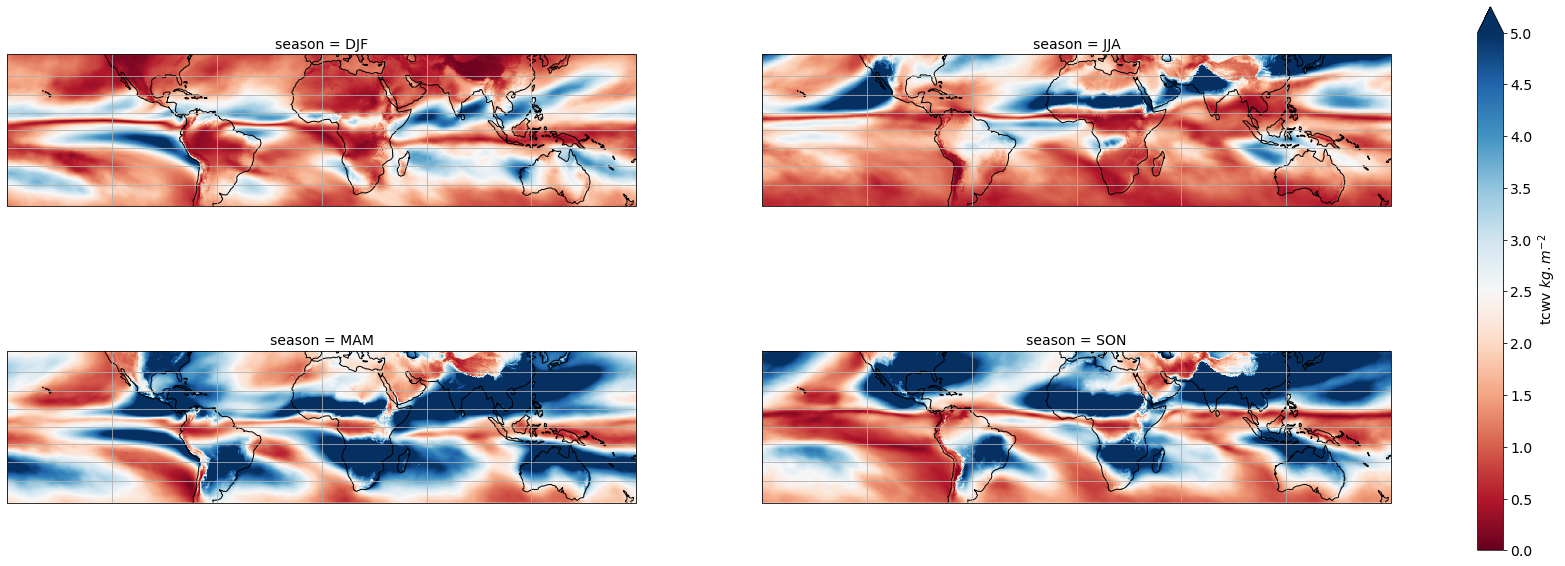

In [9]:
# plt.figure(figsize = (30,10))
p = ds_std_smot_S['tcwv_smooth'].plot(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'season', col_wrap =2,
                               aspect = aspect, size = size,
                               vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                              cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
plt.savefig(output_fig+'atlas_varSeason_clim.png')

#### Variance sur l'année

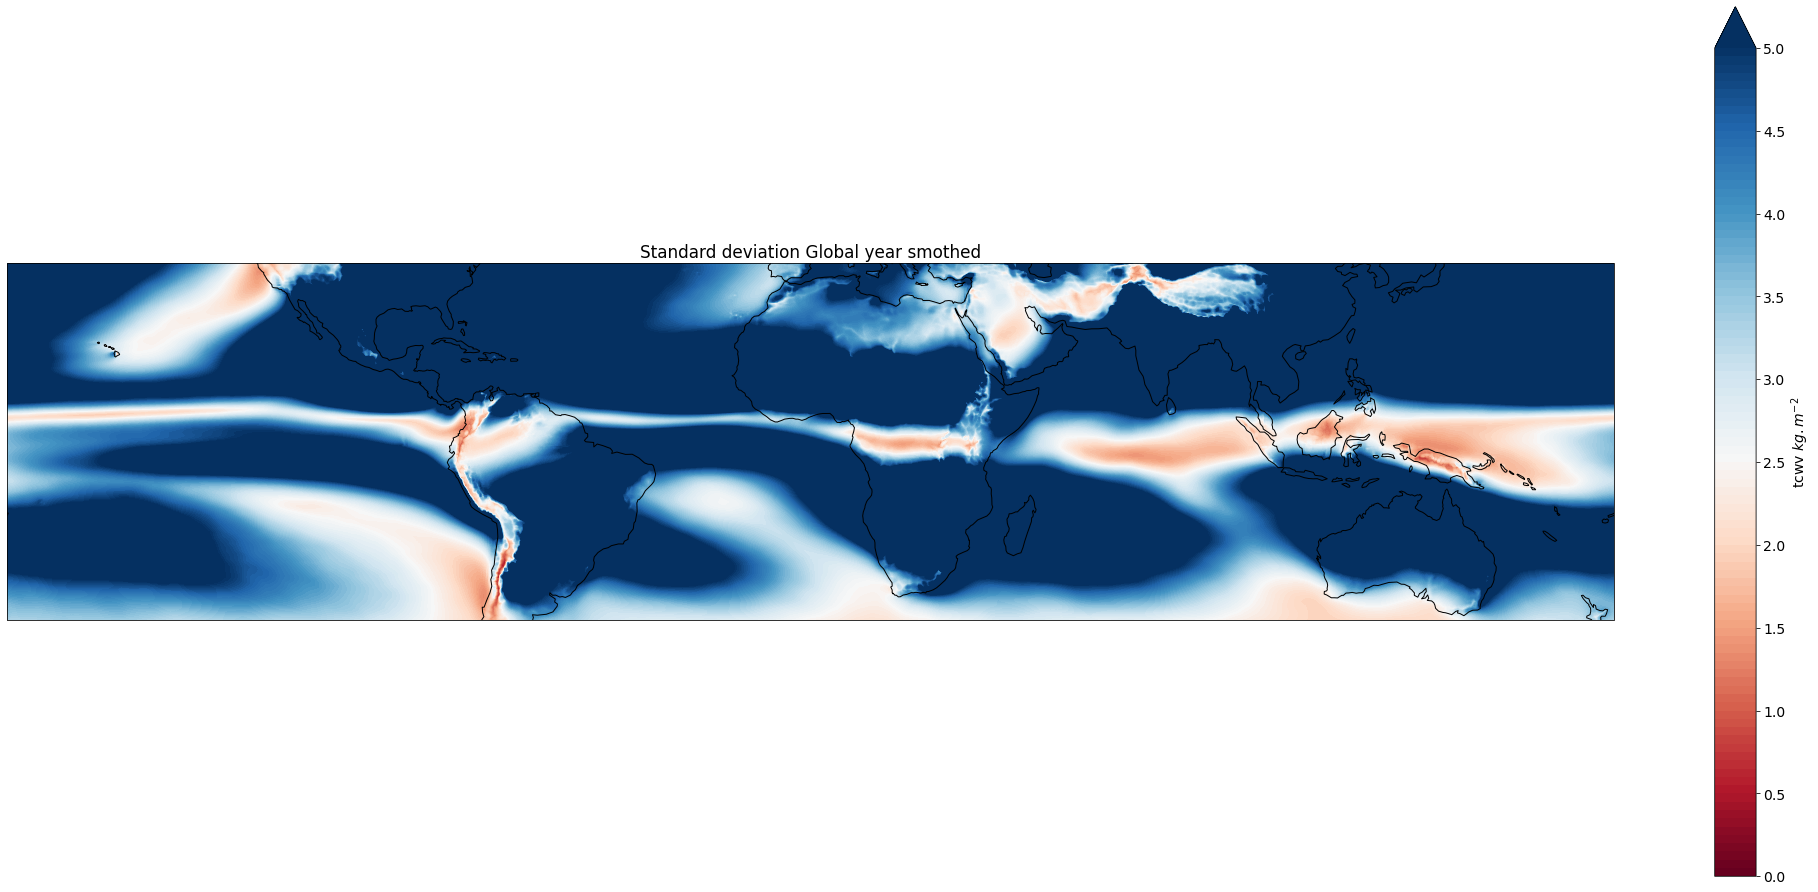

In [10]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
p = ds_std_smot['tcwv_smooth'].plot.contourf(levels = 101, vmax = vmax,vmin = vmin, cmap=cmap,
                                                      cbar_kwargs=colorbar)
ax.coastlines()
plt.title("Standard deviation Global year smothed")
plt.show()

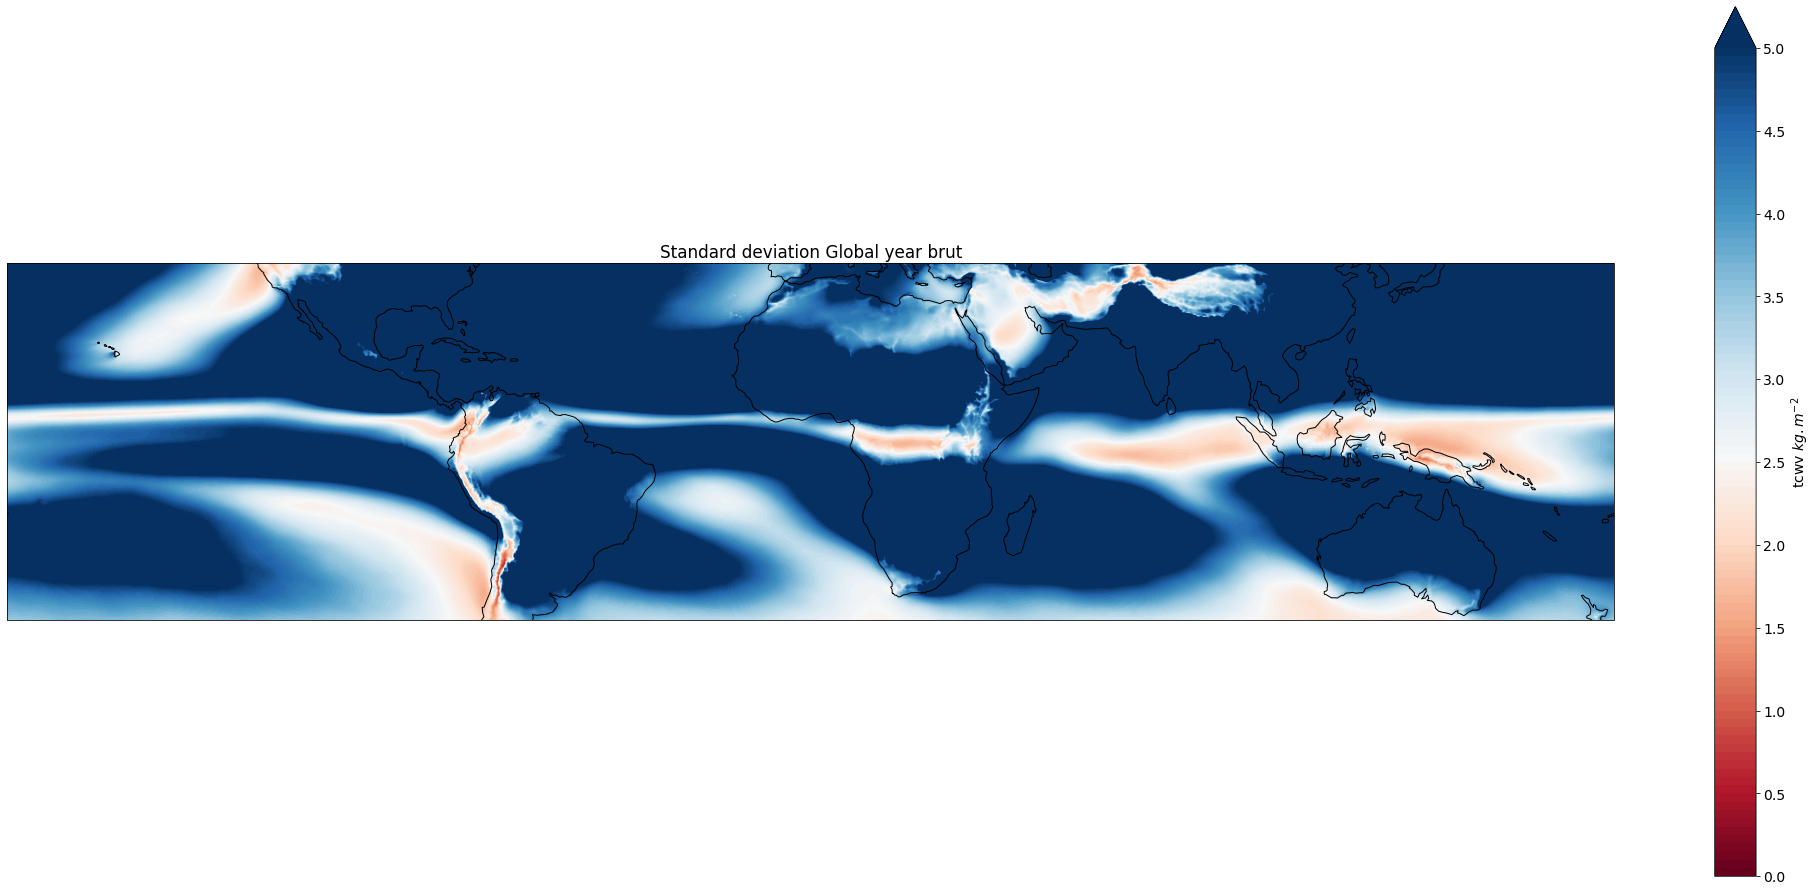

In [11]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
p = ds_std_brut['tcwv'].plot.contourf(levels = 101, vmax = vmax, vmin = vmin, cmap='RdBu',
                                                      cbar_kwargs=colorbar)
ax.coastlines()
plt.title("Standard deviation Global year brut")
plt.show()

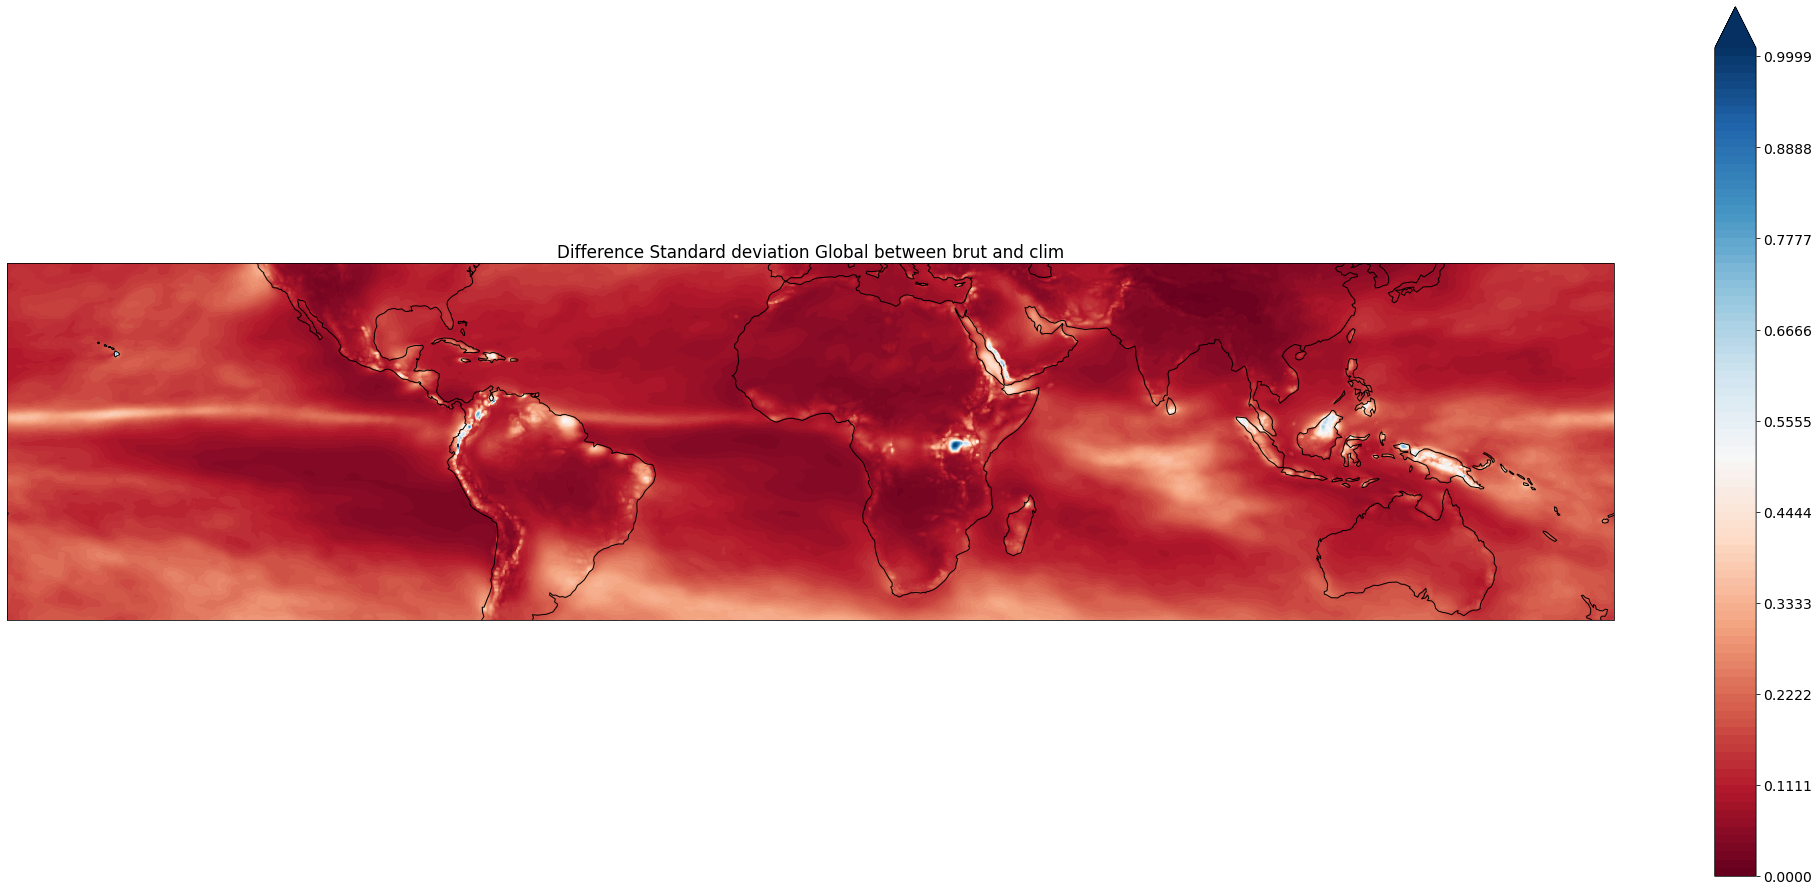

In [12]:
diff = ds_std_brut['tcwv']-ds_std_smot['tcwv_smooth']

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
p = diff.plot.contourf(levels = 101, vmax = 1.01, vmin = vmin, cmap='RdBu'
                      )
ax.coastlines()
plt.title("Difference Standard deviation Global between brut and clim")
plt.show()

In [13]:
# plt.figure()
# ax = plt.axes(projection=ccrs.PlateCarree())
# p = ds_MMS['tcwv_smooth'].sel(month = 9).plot.contourf(levels = 101, vmax = 60.,vmin = 0., cmap='RdBu_r',
#                                                       cbar_kwargs={'label': 'tcwv $kg.m^{-2}$',
#                        'orientation': 'vertical' , 'ticks': np.arange(0.,61,5)
#                         , 'extend' : 'both'})
# ax.coastlines()
# plt.title("Septembre")
# plt.show()